# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [14]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import cv2

We set the random seed so that the results don't vary drastically.

In [15]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
from keras import regularizers
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [16]:
train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
#train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
#val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 16 #experiment with the batch size  start with number like 4 & 8 (multiples of 8, 16, 32)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [17]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,3,4,5,6,8,10,11,12,13,14,16,18,20,21,22,23,24,26,27,28,29]
    x = len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size# calculate the number of batches -- force it to be an integer
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes (use if-else for required images,pixels to float)
                    #if image.shape[0] != image.shape[1]:
                        #print(iamshow)
                        #image=image[0:120,10:130]
                        
                    image = cv2.resize(image, (120,120))#, interpolation = cv2.INTER_AREA) # whats the use here #komala
                    
                    batch_data[folder,idx,:,:,0] = image[:, : , 0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, : , 1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, : , 2]/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            batch_data = np.zeros((batch_size,x,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes (use if-else for required images,pixels to float)
                    #if image.shape[0] != image.shape[1]:
                        #print(iamshow)
                        #image=image[0:120,10:130]
                    image = cv2.resize(image, (120,120))#, interpolation = cv2.INTER_AREA) # whats the use here #komala
                    
                    batch_data[folder,idx,:,:,0] = image[:, :, 0]/255#resized[:, : , 0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, :, 1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, :, 2]/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [18]:
curr_dt_time = datetime.datetime.now()
train_path = '/notebooks/storage/Final_data/Collated_training/train'
val_path = '/notebooks/storage/Final_data/Collated_training/val'
#train_path = './Project_data/train'
#val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 100 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [19]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.regularizers import l2

#write your model here 
#2d+lstm cnn
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3),
    padding='same', activation='relu'), input_shape=(24, 120, 120,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Conv2D(32, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))


model.add(TimeDistributed(Conv2D(64, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Conv2D(64, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dense(128, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(GRU(18, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [20]:
optimiser = 'SGD'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 24, 120, 120, 32)  896       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 24, 120, 120, 32)  128       
_________________________________________________________________
time_distributed_16 (TimeDis (None, 24, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 24, 60, 60, 32)    9248      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 24, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 24, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_20 (TimeDis (None, 24, 30, 30, 64)    256       
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [21]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [22]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)# write the REducelronplateau code here #how many epochs-patience
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [24]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 16Source path =  ./Project_data/train ; batch size = 16
Epoch 1/100



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 6/42 [===>..........................] - ETA: 48s - loss: 1.8945 - categorical_accuracy: 0.1562

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


42/42 [==============================] - 47s 1s/step - loss: 1.7374 - categorical_accuracy: 0.2252 - val_loss: 1.5045 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2019-12-2314_53_44.068541/model-00001-1.73571-0.22624-1.50450-0.29000.h5
Epoch 2/100
42/42 [==============================] - 17s 405ms/step - loss: 1.6836 - categorical_accuracy: 0.2619 - val_loss: 1.5024 - val_categorical_accuracy: 0.4643

Epoch 00002: saving model to model_init_2019-12-2314_53_44.068541/model-00002-1.68356-0.26190-1.50239-0.46429.h5
Epoch 3/100
42/42 [==============================] - 19s 453ms/step - loss: 1.5856 - categorical_accuracy: 0.3129 - val_loss: 1.5237 - val_categorical_accuracy: 0.2857

Epoch 00003: saving model to model_init_2019-12-2314_53_44.068541/model-00003-1.58559-0.31293-1.52370-0.28571.h5
Epoch 4/100
42/42 [==============================] - 16s 387ms/step - loss: 1.4150 - categorical_accuracy: 0.3741 - val_loss: 1.4547 - val_categorical_accuracy: 0.3214



42/42 [==============================] - 9s 208ms/step - loss: 0.7966 - categorical_accuracy: 0.7143 - val_loss: 0.8866 - val_categorical_accuracy: 0.6071

Epoch 00059: saving model to model_init_2019-12-2314_53_44.068541/model-00059-0.79658-0.71429-0.88656-0.60714.h5
Epoch 60/100
42/42 [==============================] - 9s 206ms/step - loss: 0.7860 - categorical_accuracy: 0.7143 - val_loss: 0.8573 - val_categorical_accuracy: 0.6786

Epoch 00060: saving model to model_init_2019-12-2314_53_44.068541/model-00060-0.78603-0.71429-0.85730-0.67857.h5
Epoch 61/100
42/42 [==============================] - 9s 212ms/step - loss: 0.8182 - categorical_accuracy: 0.6984 - val_loss: 0.8326 - val_categorical_accuracy: 0.6786

Epoch 00061: saving model to model_init_2019-12-2314_53_44.068541/model-00061-0.81824-0.69841-0.83258-0.67857.h5
Epoch 62/100
42/42 [==============================] - 9s 207ms/step - loss: 0.7791 - categorical_accuracy: 0.7143 - val_loss: 0.9661 - val_categorical_accuracy: 0.5714

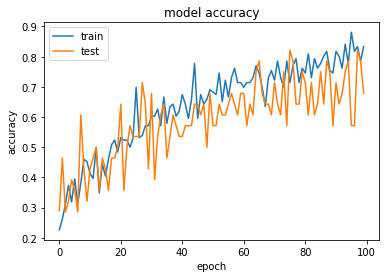

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

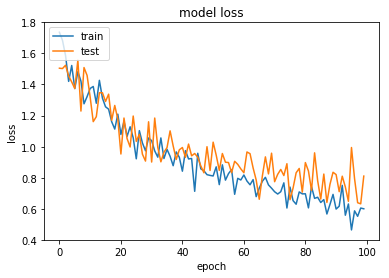

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()